# EDA

## Introduction

The exploratory data analysis (EDA) of the Cornell Movie Dialogues dataset provides insights into the structure and distribution of dialogues, conversation lengths, common words, and word patterns in the dataset. This helps us understand the data and informs the preprocessing and model-building steps. The following analysis includes visualization of dialogue lengths, most common words, question-response pairs, and n-grams, along with a co-occurrence heatmap to identify word associations.

In [ ]:
# Import the necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

### 1. Loading and Viewing the Dataset

The dialogue lines and conversation pairs are loaded from their respective files (`movie_lines.txt` and `movie_conversations.txt`). 

The `lines_df` DataFrame contains individual dialogue lines, while the `conv_df` DataFrame contains conversation pairs.

In [14]:
# Load dialogue lines from the file
lines = open('movie_lines.txt', encoding='utf-8', errors='ignore').read().split('\n')

# Load conversation pairs from the file
conversations = open('movie_conversations.txt', encoding='utf-8', errors='ignore').read().split('\n')

In [15]:
# Loading the movie_lines.txt into a DataFrame
lines_data = []
for line in lines:
    parts = line.split(' +++$+++ ')
    if len(parts) == 5:  # Ensure correct format
        lines_data.append([parts[0], parts[1], parts[2], parts[3], parts[4]])

lines_df = pd.DataFrame(lines_data, columns=['Line_ID', 'Character_ID', 'Movie_ID', 'Character_Name', 'Dialogue'])

# Loading the movie_conversations.txt into a DataFrame
conv_data = []
for conv in conversations:
    parts = conv.split(' +++$+++ ')
    if len(parts) == 4:  # Ensure correct format
        conv_data.append([parts[0], parts[1], parts[2], parts[3]])

conv_df = pd.DataFrame(conv_data, columns=['Character1_ID', 'Character2_ID', 'Movie_ID', 'Dialogue_IDs'])

# Display basic information
print("Lines DataFrame Info:")
print(lines_df.info())
print("***************************************************************************")
print("\nConversations DataFrame Info:")
print(conv_df.info())

# Preview the data
print("***************************************************************************")
print("\nLines DataFrame Head:")
print(lines_df.head())
print("***************************************************************************")
print("\nConversations DataFrame Head:")
print(conv_df.head())

Lines DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 304713 entries, 0 to 304712
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   Line_ID         304713 non-null  object
 1   Character_ID    304713 non-null  object
 2   Movie_ID        304713 non-null  object
 3   Character_Name  304713 non-null  object
 4   Dialogue        304713 non-null  object
dtypes: object(5)
memory usage: 11.6+ MB
None
***************************************************************************

Conversations DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83097 entries, 0 to 83096
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Character1_ID  83097 non-null  object
 1   Character2_ID  83097 non-null  object
 2   Movie_ID       83097 non-null  object
 3   Dialogue_IDs   83097 non-null  object
dtypes: object(4)
memory usage: 2.

- The dialogue lines are split into different components like `Line_ID`, `Character_ID`, `Movie_ID`, `Character_Name`, and `Dialogue`.
  
- The conversation pairs are split into four components: `Character1_ID`, `Character2_ID`, `Movie_ID`, and `Dialogue_IDs`.

## Distribution of Dialogue Lengths

We add a column, Dialogue_Length, to the lines_df DataFrame to calculate the number of words in each dialogue and visualize the distribution.

The Dialogue_Length column computes the number of words in each dialogue.

A histogram is plotted to observe the frequency distribution of dialogue lengths.

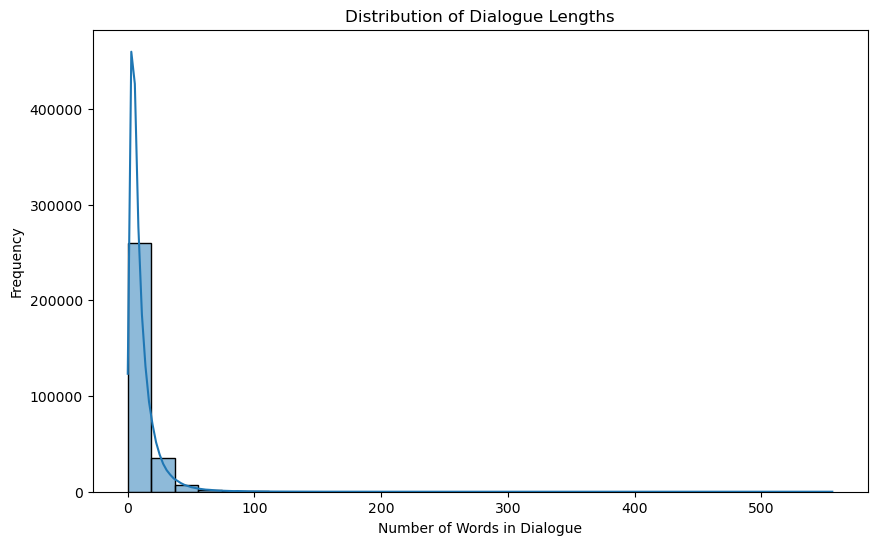

In [16]:
# Adding a 'Dialogue_Length' column to the lines DataFrame
lines_df['Dialogue_Length'] = lines_df['Dialogue'].apply(lambda x: len(x.split()))

# Plotting the distribution of dialogue lengths
plt.figure(figsize=(10, 6))
sns.histplot(lines_df['Dialogue_Length'], bins=30, kde=True)
plt.title('Distribution of Dialogue Lengths')
plt.xlabel('Number of Words in Dialogue')
plt.ylabel('Frequency')
plt.show()

## Most Common Words in the Dataset

I combine all dialogues into one large text, tokenize the words, and count the most common ones. This provides insight into frequent words used in movie dialogues.

Word counts are calculated using the Counter function.

A bar plot is created to visualize the top 20 most common words.

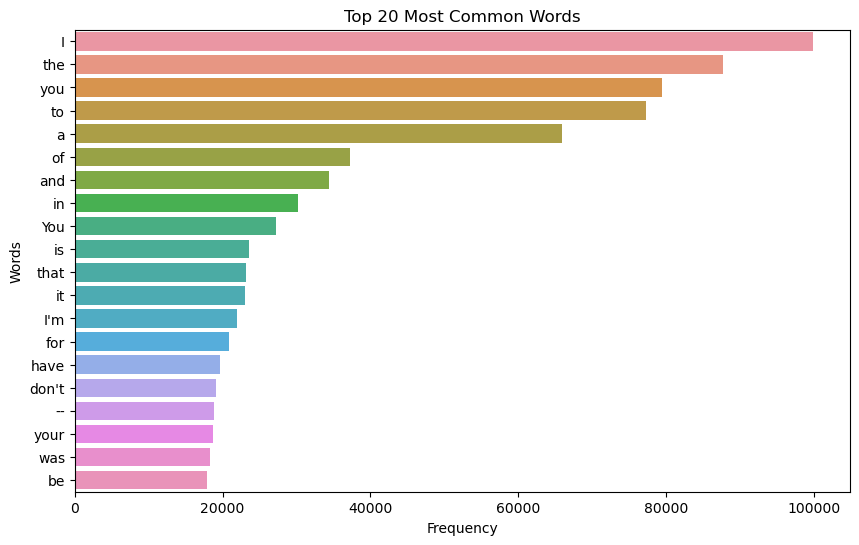

In [25]:
# Combine all dialogues into one large text
all_dialogues = ' '.join(lines_df['Dialogue'].values)

# Tokenize and count word frequencies
word_counts = Counter(all_dialogues.split())

# Plot the most common words
most_common_words = word_counts.most_common(20)
words, counts = zip(*most_common_words)

plt.figure(figsize=(10, 6))
sns.barplot(x=list(counts), y=list(words))
plt.title('Top 20 Most Common Words')
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.show()

This plot reveals the most frequently used words in the dialogues, which is useful for vocabulary selection in the model training phase.

## Word Cloud Visualization

To provide a more visual summary, a word cloud is generated to display the most frequent words in the dialogues.

A word cloud is generated using the WordCloud library to visualize word frequency by their size.

Word Cloud


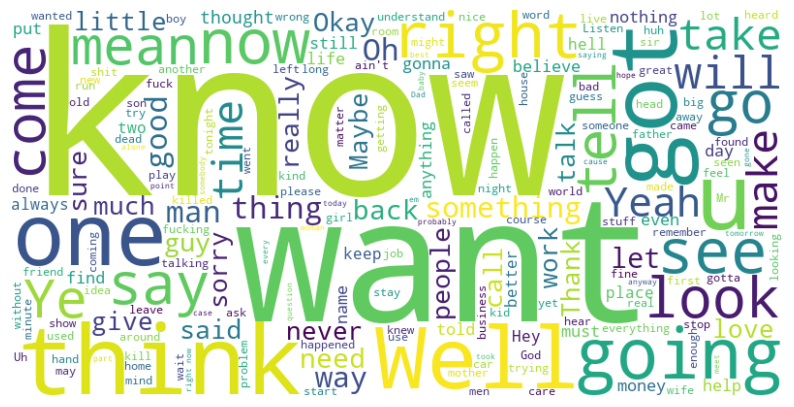

In [26]:
# Generate a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_dialogues)
print("Word Cloud")
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## Conversation Length Distribution
I calculate the length of each conversation by counting the number of dialogue pairs. The distribution helps understand how long the typical conversations are.

The Conversation_Length column in the conv_df DataFrame calculates the number of dialogue pairs in each conversation.

A histogram is plotted to show the frequency distribution of conversation lengths.

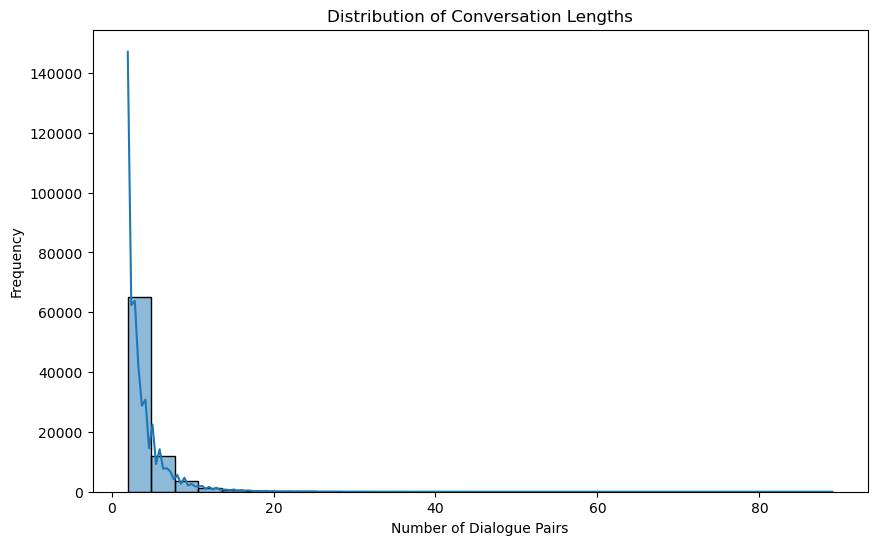

In [18]:
# Calculate the number of dialogue pairs in each conversation
conv_df['Conversation_Length'] = conv_df['Dialogue_IDs'].apply(lambda x: len(x.split()))

# Plot the distribution of conversation lengths
plt.figure(figsize=(10, 6))
sns.histplot(conv_df['Conversation_Length'], bins=30, kde=True)
plt.title('Distribution of Conversation Lengths')
plt.xlabel('Number of Dialogue Pairs')
plt.ylabel('Frequency')
plt.show()

## Frequent Question-Response Pairs
I extract question-response pairs from the conversations and visualize the top 10 most frequent pairs.

A DataFrame, pairs_df, is created to store input-response pairs.

The most frequent pairs are identified, and a bar plot is generated to visualize the top 10.

In [19]:
# Extract conversations into pairs
conversation_pairs = []
for conversation in conversations:
    conversation_pairs.append(conversation.split(' +++$+++ ')[-1][1:-1].replace("'", " ").replace(",", "").split())

# Create a dictionary mapping line IDs to dialogue text
dialogue_dict = {}
for line in lines:
    dialogue_dict[line.split(' +++$+++ ')[0]] = line.split(' +++$+++ ')[-1]

# Prepare question-answer pairs
inputs = []
responses = []

for conversation in conversation_pairs:
    for i in range(len(conversation) - 1):
        inputs.append(dialogue_dict[conversation[i]])
        responses.append(dialogue_dict[conversation[i + 1]])

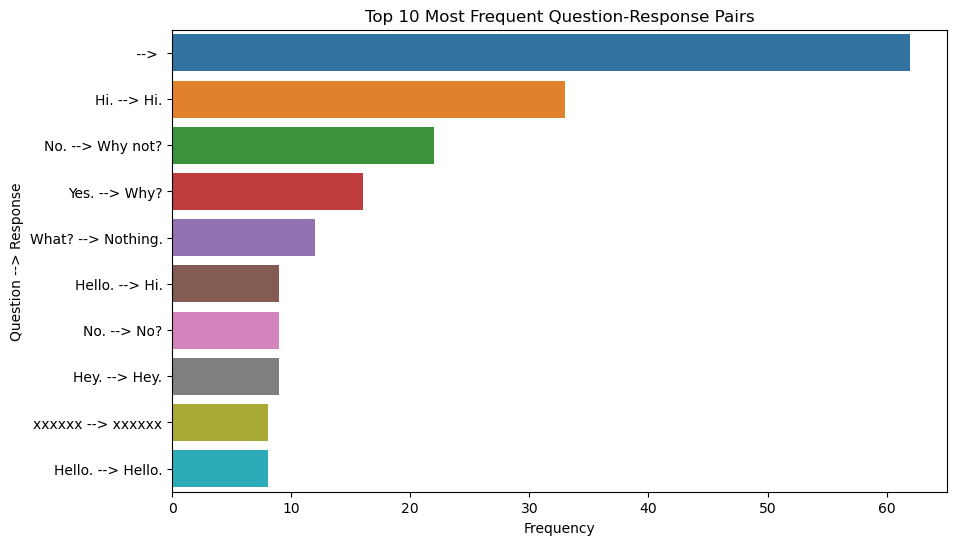

In [20]:
# Create a DataFrame of question-response pairs
pairs_df = pd.DataFrame({'Question': inputs, 'Response': responses})

# Count the most frequent pairs
frequent_pairs = pairs_df.groupby(['Question', 'Response']).size().reset_index(name='Count')
frequent_pairs = frequent_pairs.sort_values(by='Count', ascending=False).head(10)

# Visualize the top 10 most frequent question-response pairs
plt.figure(figsize=(10, 6))
sns.barplot(x=frequent_pairs['Count'], y=frequent_pairs['Question'] + ' --> ' + frequent_pairs['Response'])
plt.title('Top 10 Most Frequent Question-Response Pairs')
plt.xlabel('Frequency')
plt.ylabel('Question --> Response')
plt.show()

## N-gram Analysis (Bigrams and Trigrams)
To explore the structure of dialogues in more detail, we compute bigrams and trigrams to identify common two-word and three-word combinations.

I use CountVectorizer to extract bigrams and trigrams.

The top 10 bigrams and trigrams are visualized using bar plots.

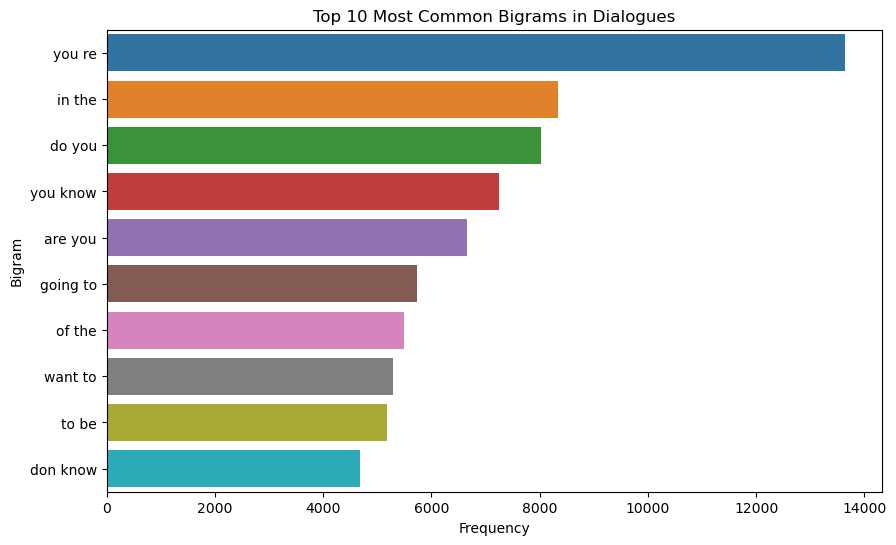

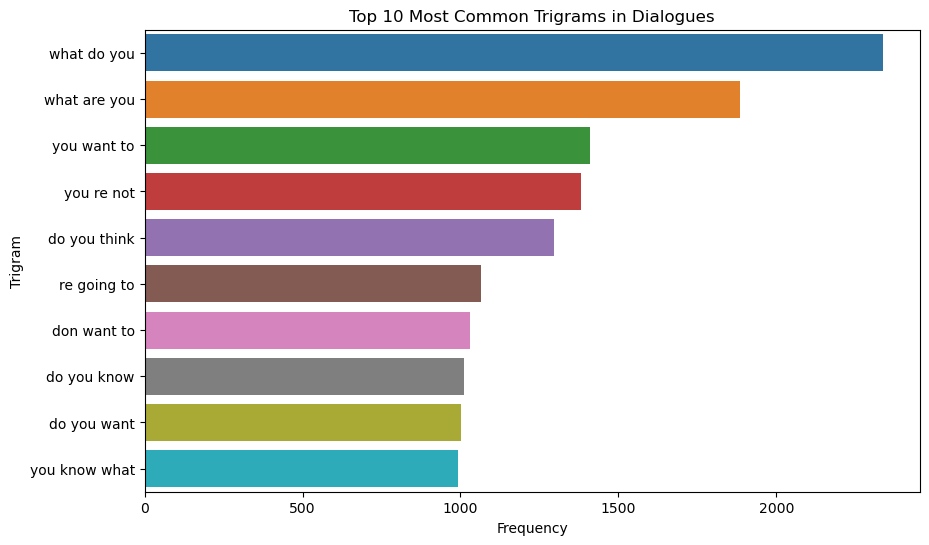

In [21]:
# Bigrams
vectorizer = CountVectorizer(ngram_range=(2, 2))
X_bigrams = vectorizer.fit_transform(lines_df['Dialogue'])

# Sum bigram counts and get the most common ones
sum_bigrams = X_bigrams.sum(axis=0)
bigrams_freq = [(word, sum_bigrams[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
bigrams_freq = sorted(bigrams_freq, key=lambda x: x[1], reverse=True)[:10]

# Convert to DataFrame for plotting
bigrams_df = pd.DataFrame(bigrams_freq, columns=['Bigram', 'Frequency'])

# Plot bigrams
plt.figure(figsize=(10, 6))
sns.barplot(x='Frequency', y='Bigram', data=bigrams_df)
plt.title('Top 10 Most Common Bigrams in Dialogues')
plt.show()

# Trigrams
vectorizer = CountVectorizer(ngram_range=(3, 3))
X_trigrams = vectorizer.fit_transform(lines_df['Dialogue'])

# Sum trigram counts and get the most common ones
sum_trigrams = X_trigrams.sum(axis=0)
trigrams_freq = [(word, sum_trigrams[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
trigrams_freq = sorted(trigrams_freq, key=lambda x: x[1], reverse=True)[:10]

# Convert to DataFrame for plotting
trigrams_df = pd.DataFrame(trigrams_freq, columns=['Trigram', 'Frequency'])

# Plot trigrams
plt.figure(figsize=(10, 6))
sns.barplot(x='Frequency', y='Trigram', data=trigrams_df)
plt.title('Top 10 Most Common Trigrams in Dialogues')
plt.show()

## Word Co-occurrence Heatmap
A heatmap is generated to visualize word co-occurrences, indicating how often words appear together in dialogues.

A TF-IDF vectorizer is used to capture word pairings.

The co-occurrence matrix is computed and visualized using a heatmap.

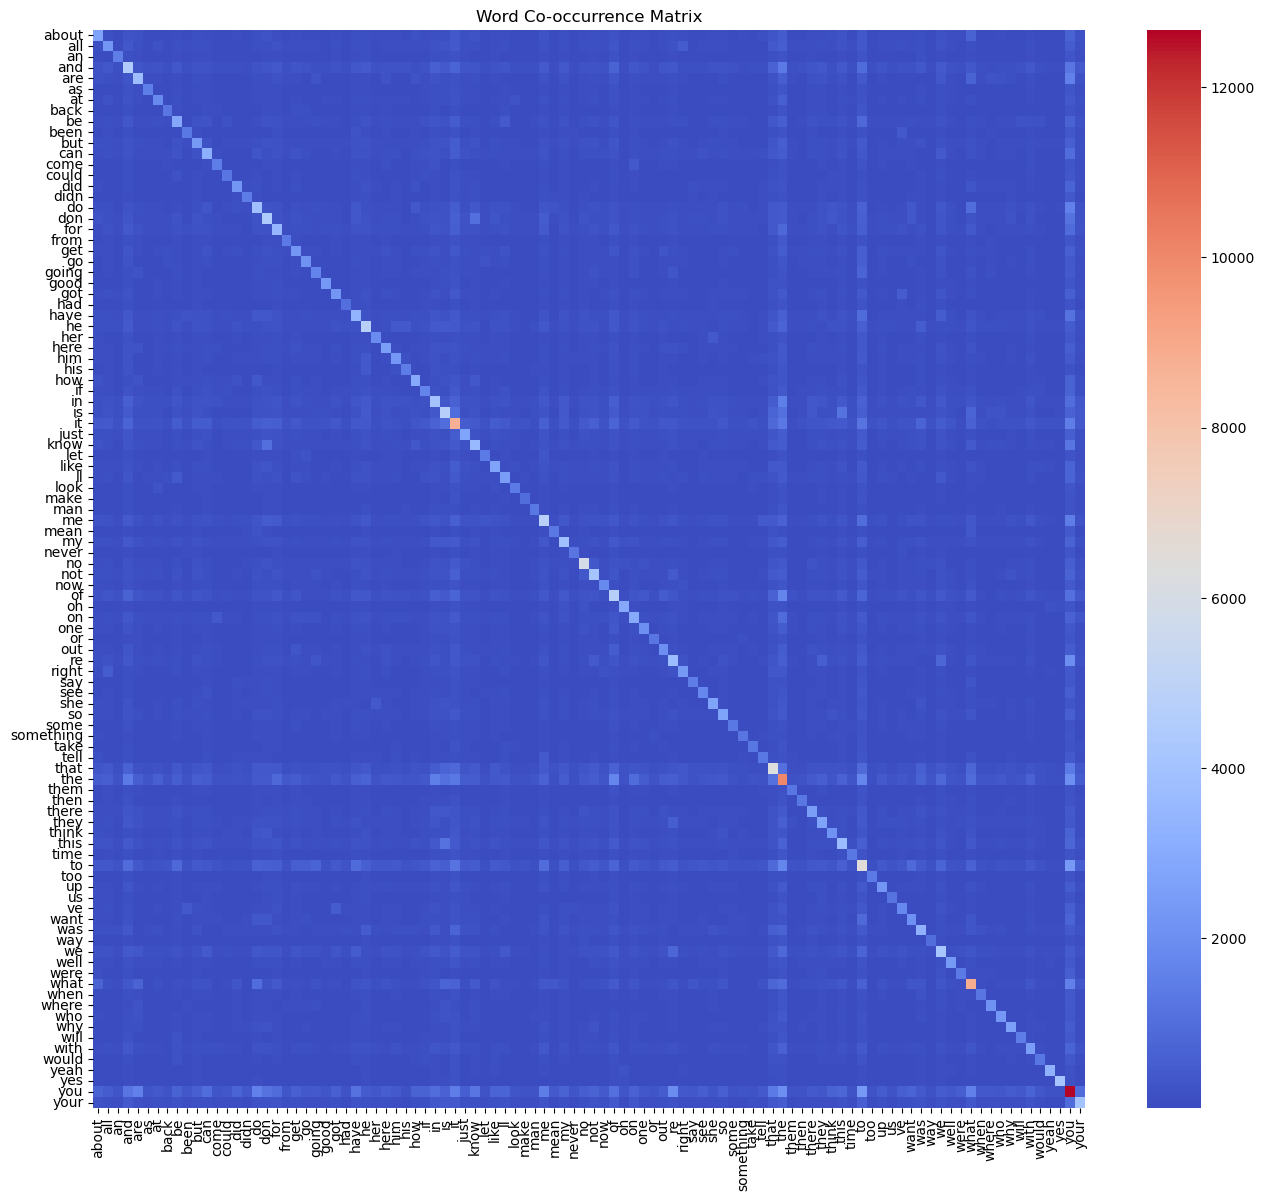

In [22]:
# Create a TF-IDF vectorizer to capture important word pairings
tfidf_vectorizer = TfidfVectorizer(max_features=100)  # Limit to top 100 words
tfidf_matrix = tfidf_vectorizer.fit_transform(lines_df['Dialogue']).toarray()

# Compute the co-occurrence matrix (word-by-word)
co_occurrence = np.dot(tfidf_matrix.T, tfidf_matrix)

# Get the words
words = tfidf_vectorizer.get_feature_names_out()

# Plot a heatmap
plt.figure(figsize=(16, 14))
sns.heatmap(co_occurrence, xticklabels=words, yticklabels=words, cmap='coolwarm')
plt.title('Word Co-occurrence Matrix')
plt.show()

##  Distribution of Response Lengths
Finally, we analyze the distribution of response lengths to understand the typical length of chatbot responses in the dataset.

The length of each response is calculated in terms of the number of words.

A histogram is plotted to show the distribution of response lengths.

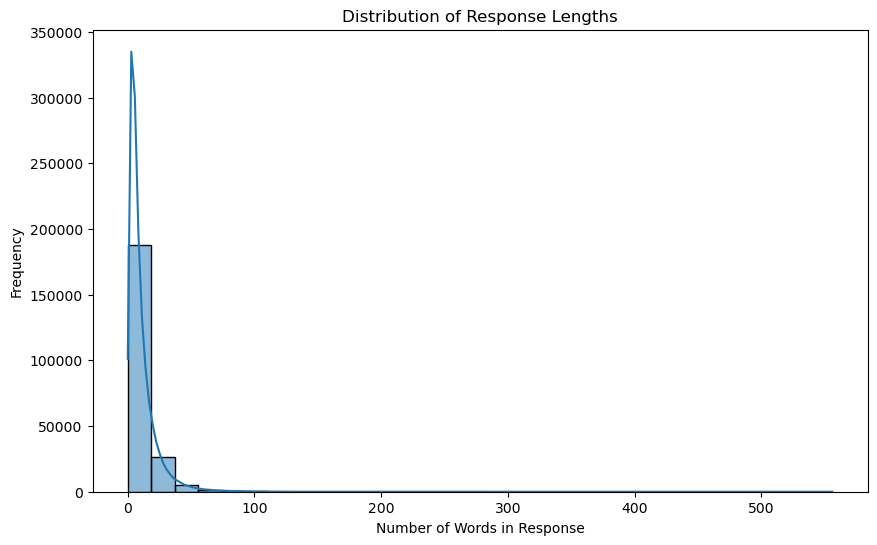

In [23]:
# Calculate response lengths
response_lengths = [len(response.split()) for response in responses]

# Plot response length distribution
plt.figure(figsize=(10, 6))
sns.histplot(response_lengths, bins=30, kde=True)
plt.title('Distribution of Response Lengths')
plt.xlabel('Number of Words in Response')
plt.ylabel('Frequency')
plt.show()